In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Install and Import the Required Libraries

In [21]:
# # Install all the required libraries

# !pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers
# !pip install langchain_text_splitters
# !pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 5.5 MB/s eta 0:00:00


In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.schema import Document

# Embedding layer - Indexing






## Extract content from pdf
return full_text => list[[page, content]]

In [3]:
def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [4]:
pdf_path = "/Users/cuong/Documents/LiveperpoolUni/Mr.HelpMateAI/Principal-Sample-Life-Insurance-Policy.pdf"
extracted_text = extract_text_from_pdf(pdf_path)
pdfs_data = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
pdfs_data['Document Name'] = pdf_path.split("/")[-1]

pdfs_data.head()

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf


In [5]:
pdfs_data['Text_Length'] = pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf,5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110


## EDA and preprocessing

Text(0, 0.5, 'Frequency')

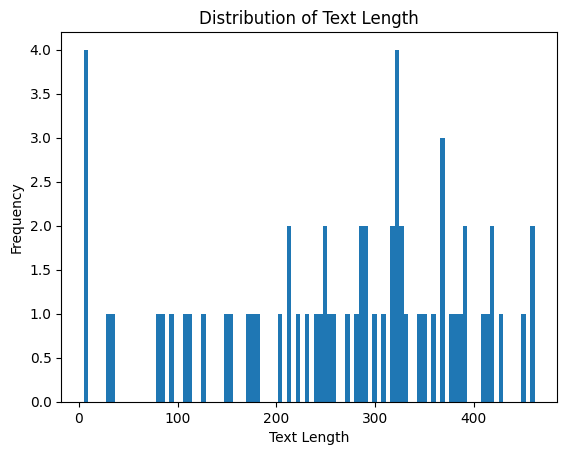

In [7]:
## Plot dist of text_length
ax = pdfs_data['Text_Length'].plot(kind='hist', bins=100, title='Distribution of Text Length')
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')

In [8]:
# Retain only the rows with a text length of at least 10

pdfs_data = pdfs_data.loc[pdfs_data['Text_Length'] >= 10]
pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


## Create metadata

In [9]:
# Store the metadata for each page in a separate column

pdfs_data['Metadata'] = pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)
pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


## Chunking and Embedding

In [17]:
# Set the API key
from dotenv import load_dotenv
load_dotenv()
import os
openai.api_key = os.environ.get("OPENAI_API_KEY")

In [12]:
# Import the OpenAI Embedding Function into chroma
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
# Define the path where chroma collections will be stored
chroma_data_path = '/Users/cuong/Documents/LiveperpoolUni/ChromaDB'

In [13]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [14]:
# Define chunking method
def chunking(method: str):
    """return TextSplitter with one chunking method"""
    if method == 'RecursiveCharacterTextSplitter':
        return RecursiveCharacterTextSplitter(
            # Set a really small chunk size, just to show.
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
        )
    elif method == 'CharacterTextSplitter':
        return CharacterTextSplitter(
            separator=" ",
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len,
            is_separator_regex=False,
        )
    else:
        raise ValueError(f"Unknown chunking method: {method}")

In [18]:
# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents
collection = client.get_or_create_collection(name='RAG_HELPMATE', embedding_function=embedding_function)
# Initialise a chunking method
text_splitter = chunking(method='RecursiveCharacterTextSplitter')

In [19]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma
documents_list = pdfs_data["Page_Text"].tolist()
metadata_list = pdfs_data['Metadata'].tolist()

In [20]:
documents = text_splitter.create_documents(
    documents_list, metadatas=metadata_list
)
documents[0]

Document(metadata={'Policy_Name': 'Principal-Sample-Life-Insurance-Policy', 'Page_No.': 'Page 1'}, page_content='DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014')

In [21]:
print(len(documents))
print(len(documents_list))

141
60


In [22]:
split_document_list = [doc.page_content for doc in documents]
split_metadata_list = [doc.metadata for doc in documents]


In [23]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.
collection.add(
    documents= split_document_list,
    ids = [str(i) for i in range(0, len(split_document_list))],
    metadatas = split_metadata_list
)

In [24]:
# Let's take a look at the first few entries in the collection

collection.get(
    ids = ['0','1'],
    include = ['documents', 'metadatas']
)

{'ids': ['0', '1'],
 'embeddings': None,
 'metadatas': [{'Page_No.': 'Page 1',
   'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
  {'Page_No.': 'Page 3',
   'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}],
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, hea

# Searching layer

## caching

In [25]:
# cache_collection = client.get_or_create_collection(name='Cache', embedding_function=embedding_function)

In [42]:
cache_collection = client.get_or_create_collection(name='Cache', embedding_function=embedding_function)
query = "What is the print date?"
results = collection.query(
          query_texts=query,
          n_results=10
          )
results

{'ids': [['36', '60', '61', '38', '37', '58', '140', '96', '52', '88']],
 'distances': [[0.48858171701431274,
   0.49551770091056824,
   0.5133541226387024,
   0.5210309624671936,
   0.5250705480575562,
   0.5270731449127197,
   0.5297504386368884,
   0.5404967069625854,
   0.5413839817047119,
   0.5437260270118713]],
 'metadatas': [[{'Page_No.': 'Page 20',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 31',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 31',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 21',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 21',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 30',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 62',
    'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'},
   {'Page_No.': 'Page 45',
    'Policy_Name'

In [50]:
# Implementing Cache in Semantic Search
class Caching():
  def __init__(self, collection):
    self.collection = collection
    self.cache_collection = client.get_or_create_collection(name='Cache', embedding_function=embedding_function)
    self.threshold = 0.2
    self.ids = []
    self.documents = []
    self.distances = []
    self.metadatas = []


  def search(self, query):
    cache_results = self.cache_collection.query(
        query_texts=query,
        n_results=1
    )
    # If the distance is greater than the threshold, then return the results from the main collection.
    if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > self.threshold:
          # Query the collection against the user query and return the top 10 results
          results = self.collection.query(
          query_texts=query,
          n_results=10
          )

          # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
          # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
          Keys = []
          Values = []

          for key, val in results.items():
            if val is None:
              continue
            for i in range(10):
              try:
                Keys.append(str(key)+str(i))
                Values.append(str(val[0][i]))
              except:
                 pass


          self.cache_collection.add(
              documents= [query],
              ids = [query], #[len(cache_results['documents'])],   # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
              metadatas = dict(zip(Keys, Values))
          )

          print("Not found in cache. Found in main collection.")

          result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
          results_df = pd.DataFrame.from_dict(result_dict)


    # If the distance is, however, less than the threshold, you can return the results from cache

    elif cache_results['distances'][0][0] <= self.threshold:
          cache_result_dict = cache_results['metadatas'][0][0]

          # Loop through each inner list and then through the dictionary
          for key, value in cache_result_dict.items():
              if 'ids' in key:
                  self.ids.append(value)
              elif 'documents' in key:
                  self.documents.append(value)
              elif 'distances' in key:
                  self.distances.append(value)
              elif 'metadatas' in key:
                  self.metadatas.append(value)

          print("Found in cache!")

          # Create a DataFrame
          results_df = pd.DataFrame({
            'IDs': self.ids,
            'Documents': self.documents,
            'Distances': self.distances,
            'Metadatas': self.metadatas
          })
    return results_df


In [51]:
# Initial the caching
cache = Caching(collection)

In [52]:
results_df = cache.search("What is the print date?")
results_df

Not found in cache. Found in main collection.


,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi...",then been in force 24 months or more and if Wr...,0.488582,36
1,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",date Proof of Good Health is approved by The P...,0.495518,60
2,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi...",Member for which Proof of Good Health is requi...,0.513354,61
3,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",the volume of insurance for then insured Membe...,0.521031,38
4,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi...",b . on any date the definition of Member or De...,0.525071,37
5,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi...",Scheduled Benefit amount because of a change i...,0.527073,58
6,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi...",may be started later than three years after th...,0.529750,140
7,"{'Page_No.': 'Page 45', 'Policy_Name': 'Princi...",which the Dependent becomes eligible under any...,0.540497,96
8,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi...",under this Group Policy replaces coverage unde...,0.541384,52
9,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Disability . c. Application/Effective Date Not...,0.543726,88


In [53]:
results_df = cache.search("when is the print date?")
results_df

Found in cache!


,IDs,Documents,Distances,Metadatas
0,36,then been in force 24 months or more and if Wr...,0.48858171701431274,"{'Page_No.': 'Page 20', 'Policy_Name': 'Princi..."
1,60,date Proof of Good Health is approved by The P...,0.49551770091056824,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."
2,61,Member for which Proof of Good Health is requi...,0.5133541226387024,"{'Page_No.': 'Page 31', 'Policy_Name': 'Princi..."
3,38,the volume of insurance for then insured Membe...,0.5210309624671936,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
4,37,b . on any date the definition of Member or De...,0.5250705480575562,"{'Page_No.': 'Page 21', 'Policy_Name': 'Princi..."
5,58,Scheduled Benefit amount because of a change i...,0.5270731449127197,"{'Page_No.': 'Page 30', 'Policy_Name': 'Princi..."
6,140,may be started later than three years after th...,0.5297504386368884,"{'Page_No.': 'Page 62', 'Policy_Name': 'Princi..."
7,96,which the Dependent becomes eligible under any...,0.5404967069625854,"{'Page_No.': 'Page 45', 'Policy_Name': 'Princi..."
8,52,under this Group Policy replaces coverage unde...,0.5413839817047119,"{'Page_No.': 'Page 28', 'Policy_Name': 'Princi..."
9,88,Disability . c. Application/Effective Date Not...,0.5437260270118713,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi..."
